# ANALIZA PODATKOV
Na tem mestu bomo naredili analizo podatkov, ki so zbrani v csv datotekah v mapi podatki. Analizirali bomo po treh dejavnikih:
* analiza najstarejših prebivalcev in povprečni življenjski dobi po državah
* analiza najstarejših prebivalcev in gospodarskega razvoja držav
* analiza najstarejših prebivalcev in naravnih zalog


Naložimo pandas in omejimo velikot tabel na največ 15 vrstic.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 15)
%matplotlib inline


Shranimo vse csv datoteke.

In [40]:
najstarejsi_prebivalci = pd.read_csv("podatki/najstarejsi_prebivalci_po_drzavah.csv", index_col="Država")
pricakovana_zivljenjska_doba = pd.read_csv("podatki/pricakovana_zivljenjska_doba_po_drzavah.csv", index_col="Država")
GDP_po_drzavah = pd.read_csv("podatki/GDP_po_drzavah.csv", index_col="Država")
podhranjenost_po_drzavah = pd.read_csv("podatki/podhranjenost_po_drzavah.csv", index_col="Država")
poraba_energije_po_drzavah = pd.read_csv("podatki/poraba_energije_po_drzavah.csv", index_col="Država")
obnovljiva_energija_po_drzavah = pd.read_csv("podatki/obnovljiva_energija_po_drzavah.csv", index_col="Država")
CO2_emisije_po_drzavah = pd.read_csv("podatki/CO2_emisije_po_drzavah.csv", index_col="Država")
kolicina_vode_po_drzavah = pd.read_csv("podatki/kolicina_vode_po_drzavah.csv", index_col="Država")


## Analiza po najstarejših prebivalcih in pričakovani življenjski dobi
V tem sklopu ananlize podatkov bomo primerjali starost najstarejših oseb po državah in pričakovani življenjski dobi po državah. Sprva bomo uredili tabelo najstarejših prebivalcev, nato ju bomo združili. Vsaka država bo imela moškega in žensko predstavnico, ki bosta izbrana na podlagi najdaljšega življenja (saj imajo nekatere države več kot dva predstavnika). Če država nima enaga od predstavnikov, ga bomo izpustili. Hkrati se tudi lahko zgodi, da nekaterih držav ni navedenih v obeh tabelah podatkov. Te države prav tako izpustimo.  

In [41]:
# Najprej dodamo še en stolpec, predstavlja starost v decimalnem zapisu
najstarejsi_prebivalci['Starost'] = najstarejsi_prebivalci['Starost (leta)'] + najstarejsi_prebivalci['Starost (dnevi)']/365
najstarejsi_prebivalci['Starost'] = najstarejsi_prebivalci['Starost'].round(2)
# Razvrstimo po starosti (najprej leta padajoče, nato dnevi padajoče) znotraj države in spola
najstarejsi_prebivalci_vrstni_red = najstarejsi_prebivalci.sort_values(by=['Država', 'Spol', 'Starost (leta)', 'Starost (dnevi)'], ascending=[True, True, False, False])

# Za vsako kombinacijo države in spola vzamemo prvo vrstico (najstarejšo)
najstarejsi_prebivalci_urejena = najstarejsi_prebivalci_vrstni_red.groupby(['Država', 'Spol']).first().reset_index()

# Zdaj imamo za vsako državo in spol eno vrstico
# Za vsako državo vzamemo največ dve vrstici (eno za vsak spol)
# Najprej dodamo pomocni stolpec za razvrstitev znotraj države (po spolu, npr. F prvi, M drugi)
najstarejsi_prebivalci_urejena['Spol_razvrstitev'] = najstarejsi_prebivalci_urejena['Spol'].apply(lambda x: 0 if x == 'F' else 1)
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_urejena.sort_values(by=['Država', 'Spol_razvrstitev'])

# Zdaj za vsako državo vzamemo največ dve vrstici
najstarejsi_prebivalci_sortirana.groupby('Država').head(2).reset_index(drop=True)

# Odstranimo pomocni stolpec
najstarejsi_prebivalci_sortirana = najstarejsi_prebivalci_sortirana.drop(columns=['Spol_razvrstitev'])
najstarejsi_prebivalci_sortirana

,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46
2,Algeria,F,5 October 1890,26 March 20059,114,172,114.47
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18
...,...,...,...,...,...,...,...
167,United States,M,16 August 1882,25 April 1998,115,252,115.69
168,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21
169,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32
170,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34


Sedaj združimo to tabelo s tabelo o pričakovani življenjski dobi. Združili jih bomo tako, da v nov stolpec dodamo indeks pričakovane življenjske dobe, ki je odvisen od države in spola osebe.

In [42]:
# Združimo tabeli po državi
zdruzena_tabela = pd.merge(najstarejsi_prebivalci_sortirana, pricakovana_zivljenjska_doba, on='Država', how='left')

# Dodamo nov stolpec z indeksom pričakovane življenjske dobe
zdruzena_tabela['Pričakovana življenjska doba po spolu'] = zdruzena_tabela.apply(
    lambda row: row['Pričakovana življenjska doba (ženske)'] if row['Spol'] == 'F' 
    else row['Pričakovana življenjska doba (moški)'] if row['Spol'] == 'M' 
    else None, 
    axis=1
)

# Razvrstimo po državah in spolu
zdruzena_tabela = zdruzena_tabela.sort_values(by=['Država', 'Spol'])
zdruzena_tabela = zdruzena_tabela.drop(columns=['Pričakovana življenjska doba', 'Pričakovana življenjska doba (ženske)', 'Pričakovana življenjska doba (moški)'])
zdruzena_tabela



,Država,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost,Pričakovana življenjska doba po spolu
0,Albania,F,10 May 1910,5 July 2021,111,56,111.15,81.74
1,Albania,M,13 February 1911,31 July 2020,109,169,109.46,78.12
2,Algeria,F,5 October 1890,26 March 20059,114,172,114.47,78.13
3,Algeria,M,29 July 1884,29 December 1995,111,153,111.42,75.30
4,Angola,F,17 June 1911,20 August 2023,112,64,112.18,67.54
...,...,...,...,...,...,...,...,...
167,United States,M,16 August 1882,25 April 1998,115,252,115.69,77.22
168,Uruguay,F,15 May 1904,29 July 2016,112,75,112.21,82.17
169,Uruguay,M,20 November 1911,18 March 2022,110,118,110.32,74.59
170,Venezuela,F,9 August 1911,12 December 2023,112,125,112.34,76.82


Z grafom predstavimo podatke spodnje tabele - starost s pričakovano življenjsko dobo po spolu.

In [43]:
graf1_tabela = zdruzena_tabela[['Starost', 'Pričakovana življenjska doba po spolu']]
graf1_tabela 

,Starost,Pričakovana življenjska doba po spolu
0,111.15,81.74
1,109.46,78.12
2,114.47,78.13
3,111.42,75.30
4,112.18,67.54
...,...,...
167,115.69,77.22
168,112.21,82.17
169,110.32,74.59
170,112.34,76.82


<Axes: title={'center': 'Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo'}, xlabel='Pričakovana življenjska doba', ylabel='Starost'>

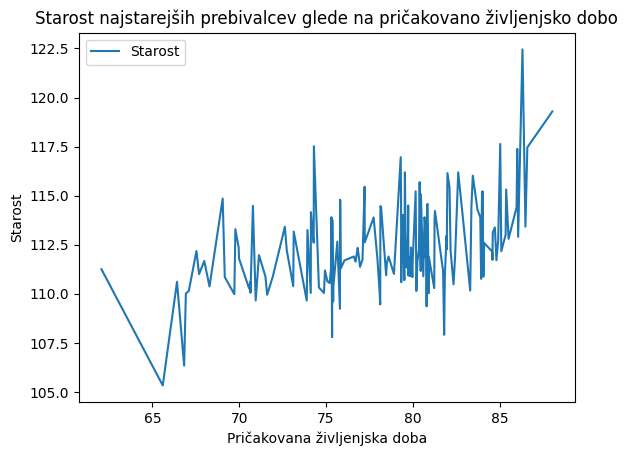

In [44]:
graf1_tabela.groupby("Pričakovana življenjska doba po spolu").mean().plot(
    ylabel = "Starost", xlabel = "Pričakovana življenjska doba",
    title = "Starost najstarejših prebivalcev glede na pričakovano življenjsko dobo")

Opaženo je tako, da je korelacija med starostjo in pričakovano življenjsko dobo, saj graf narašča.

## Analiza najstarejših prebivalcev in gospodarskega razvoja držav
V tem razdelku bomo analizirali podatke o starosti najstarejših prebivalcev in energetskem razvoju držav. Sklepamo, da bi lahko starost najstarejših prebivalcev lahko bila odvisna od razvitosti države, ki jo bomo v tem primeru merili s količino porabljeno energije, odstotkom pridobljene "zelene energije", količino odvedenih CO2 emisij ter nenazadnje še z BDP-jem.
Sprva v tabeli najstarejših prebivalcev ohranimo le najstarejše predstavnike držav, saj v tem primeru nimamo razporejenih podatkov po spolu. Nato tabeli dodamo štiri nove stolpce zgoraj navedenih količin.

In [45]:

# Resetirajmo indeks, da bo 'Država' postal stolpec
najstarejsi_prebivalci_reset = najstarejsi_prebivalci.reset_index()
# Uporabimo fukcijo drop_duplicates, da dobimo najstarejšega prebivalca v vsaki državi
najstarejsi_prebivalci_ekonomija_urejena = najstarejsi_prebivalci_reset.sort_values(by=['Starost'], ascending=False)
najstarejsi_prebivalci_ekonomija_sortirana = najstarejsi_prebivalci_ekonomija_urejena.drop_duplicates(subset='Država', keep='first')
najstarejsi_prebivalci_ekonomija = najstarejsi_prebivalci_ekonomija_sortirana.sort_values('Država')
najstarejsi_prebivalci_ekonomija = najstarejsi_prebivalci_ekonomija.set_index('Država')# Nastavimo 'Država' kot indeks
najstarejsi_prebivalci_ekonomija

,Spol,Datum rojstva,Datum smrti,Starost (leta),Starost (dnevi),Starost
Država,,,,,,
Albania,F,10 May 1910,5 July 2021,111,56,111.15
Algeria,F,5 October 1890,26 March 20059,114,172,114.47
Angola,F,17 June 1911,20 August 2023,112,64,112.18
Antigua and Barbuda,F,23 January 1902,8 September 2012,110,229,110.63
Argentina,F,8 April 1907,28 June 202215,115,81,115.22
...,...,...,...,...,...,...
Ukraine,F,10 June 1906,19 August 2022,116,70,116.19
United Kingdom,F,21 August 1909,Living,116,6,116.02
United States,F,24 September 1880,30 December 1999,119,97,119.27


In [46]:
tabele = [poraba_energije_po_drzavah, obnovljiva_energija_po_drzavah, CO2_emisije_po_drzavah, GDP_po_drzavah]

# Začnemo z osnovno tabelo in jih potem postopoma združujemo.
zdruzena_tabela = najstarejsi_prebivalci_ekonomija.copy()
for tabela in tabele:
    zdruzena_tabela = pd.merge(zdruzena_tabela, tabela, on='Država', how='left')

# Izberemo želene stolpce
tabela_ekonomije = zdruzena_tabela[['Starost', 'Odstotek porabe energije (svetovno)', 
                                   'Porabljena energija na prebivalca (letno)', 'Odstotek pridobljene obnovljive energije',
                                   'CO2 emisije na prebivalca (v tonah)', 'Delež svetovnega CO2 (v odstotkih)', 'GDP rast (v odstotkih)',
                                   'GDP na prebivalca (v dolarjih)', 'Delež svetovnega GDP (v odstotkih)']]

# Odstramimo vrstice z manjkajočimi vrednostmi.
tabela_ekonomije = tabela_ekonomije.dropna() 
tabela_ekonomije  



,Starost,Odstotek porabe energije (svetovno),Porabljena energija na prebivalca (letno),Odstotek pridobljene obnovljive energije,CO2 emisije na prebivalca (v tonah),Delež svetovnega CO2 (v odstotkih),GDP rast (v odstotkih),GDP na prebivalca (v dolarjih),Delež svetovnega GDP (v odstotkih)
Država,,,,,,,,,
Albania,111.15,0.0190,38590.0,100.0,1.59,0.01200,3.94,8375.0,0.0220
Algeria,114.47,0.4100,57531.0,0.9,3.89,0.46000,4.10,5364.0,0.2300
Angola,112.18,0.0620,12000.0,76.0,0.57,0.05200,1.00,2308.0,0.0800
Antigua and Barbuda,110.63,0.0018,117227.0,6.0,2.99,0.00072,3.86,21787.0,0.0019
Argentina,115.22,0.6600,87325.0,34.0,4.05,0.48000,-1.61,14187.0,0.6100
...,...,...,...,...,...,...,...,...,...
Turkey,114.50,1.1000,77422.0,42.0,5.53,1.25000,5.11,12814.0,1.0500
Ukraine,116.19,0.6200,79941.0,17.0,3.23,0.34000,5.32,4737.0,0.1700
United Kingdom,116.02,1.4100,123441.0,47.0,5.00,0.88000,0.34,49224.0,3.1800


Sedaj primeerjavo vse štiri količine s starostjo najstarejših prebivalcev.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na porabljeno energijo'}, xlabel='Porabljena energija na prebivalca (letno)', ylabel='Starost'>

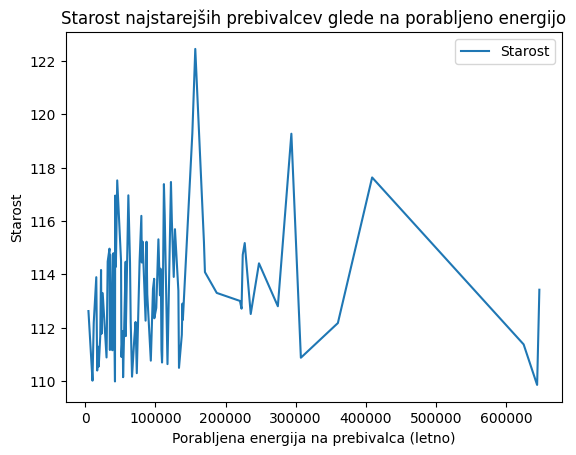

In [47]:
tabela_ekonomije_energija_urejena = tabela_ekonomije.sort_values(by=['Porabljena energija na prebivalca (letno)'], ascending=True)
tabela_ekonomije_energija_urejena[['Porabljena energija na prebivalca (letno)', 'Starost']].groupby('Porabljena energija na prebivalca (letno)').mean().plot(
    ylabel = "Starost", xlabel = "Porabljena energija na prebivalca (letno)",
    title = "Starost najstarejših prebivalcev glede na porabljeno energijo")


Iz grafa se opazi, da trend morda še nekoliko narašča do 100.000 porabljene energije, nato pa se zgodijo same anomalije.
Poglejmo si graf obnovljene energije glede na starost najstarejših prebivalcev.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na obnovljivo energijo'}, xlabel='Pridobljena obnovljiva enegija v (%)', ylabel='Starost'>

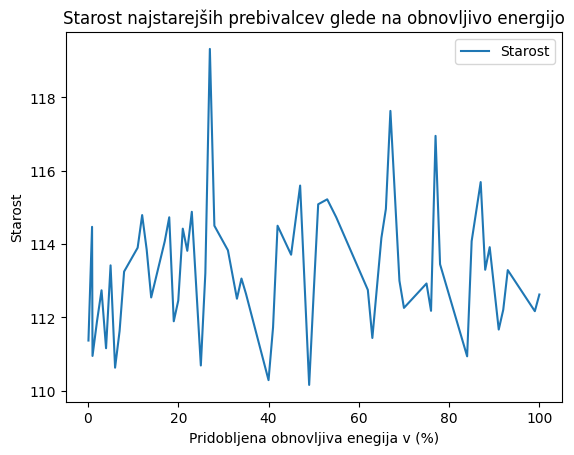

In [48]:
tabela_ekonomije_obnovljiva_energija_urejena = tabela_ekonomije.sort_values(by=['Odstotek pridobljene obnovljive energije'], ascending=True)
tabela_ekonomije_obnovljiva_energija_urejena[['Odstotek pridobljene obnovljive energije', 'Starost']].groupby('Odstotek pridobljene obnovljive energije').mean().plot(
    ylabel = "Starost", xlabel = "Pridobljena obnovljiva enegija v (%)",
    title = "Starost najstarejših prebivalcev glede na obnovljivo energijo")

V tem grafu je vidno, da ni nobene povezave med starostjo najstarejših prebivalcev in pridobljeno obnovljivo energijo. To je seveda posledica tega, da je v manjših državah zagotovo lažje doseči odstotek energije pridobljene iz obnovljivih virov kot v večjih državah. Hkrati pa je seveda starost najstarejših prebivalcev po državah lahko tudi posledica številčnosti prebivalstva - v državi z več prebivalstva je večja možnost, da bo imela več ljudi, ki bodo dosegli zelo veliko starost.
Poglejmo si še grafa CO2 emisij in BDP-ja. 

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na CO2 emisije'}, xlabel='CO2 emisije na prebivalca (v tonah)', ylabel='Starost'>

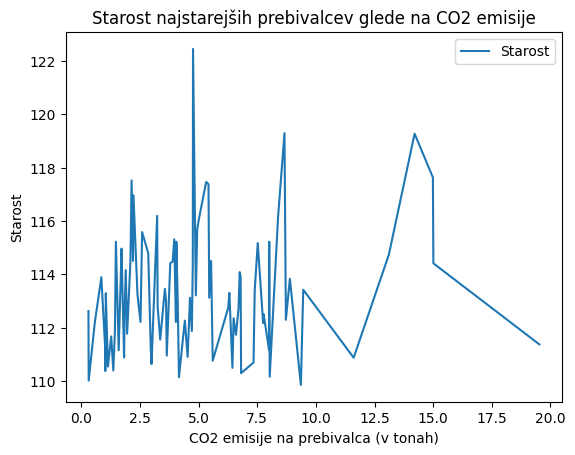

In [49]:
tabela_ekonomije_CO2_urejena = tabela_ekonomije.sort_values(by=['CO2 emisije na prebivalca (v tonah)'], ascending=True)
tabela_ekonomije_CO2_urejena[['CO2 emisije na prebivalca (v tonah)', 'Starost']].groupby('CO2 emisije na prebivalca (v tonah)').mean().plot(
    ylabel = "Starost", xlabel = "CO2 emisije na prebivalca (v tonah)",
    title = "Starost najstarejših prebivalcev glede na CO2 emisije")

CO2 emisije nimajo povezave z starostjo.

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na BDP'}, xlabel='BDP na prebivalca (v dolarjih)', ylabel='Starost'>

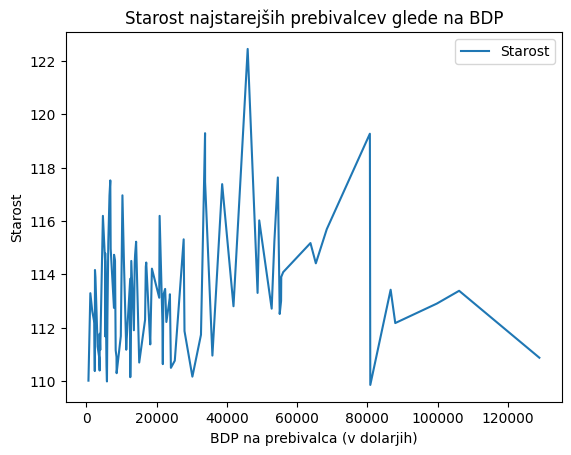

In [50]:
tabela_ekonomije_GDP_urejena = tabela_ekonomije.sort_values(by=['GDP na prebivalca (v dolarjih)'], ascending=True)
tabela_ekonomije_GDP_urejena[['GDP na prebivalca (v dolarjih)', 'Starost']].groupby('GDP na prebivalca (v dolarjih)').mean().plot(
    ylabel = "Starost", xlabel = "BDP na prebivalca (v dolarjih)",
    title = "Starost najstarejših prebivalcev glede na BDP")

<Axes: title={'center': 'Starost najstarejših prebivalcev glede na BDP rast'}, xlabel='BDP rast (v odstotkih)', ylabel='Starost'>

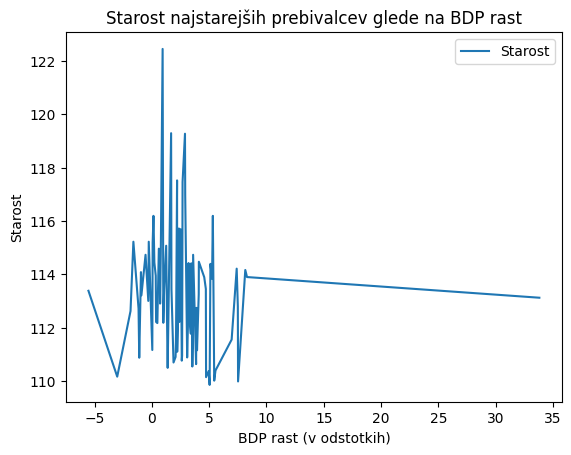

In [52]:
tabela_ekonomije_GDP_rast_urejena = tabela_ekonomije.sort_values(by=['GDP rast (v odstotkih)'], ascending=True)
tabela_ekonomije_GDP_rast_urejena[['GDP rast (v odstotkih)', 'Starost']].groupby('GDP rast (v odstotkih)').mean().plot(
    ylabel = "Starost", xlabel = "BDP rast (v odstotkih)",
    title = "Starost najstarejših prebivalcev glede na BDP rast")

Iz zadnjih dveh graf sklepamo, da je vidna povezava s starostjo prebivalstva. V prvem grafu se opazi, da je graf ločen na dva dela - prvi del je do okoli 30.000 dolarjev, drugi pa od 30.000 dolarjev naprej. Prvi del je zagotovo manjši od drugega, klub temu pa je povezavo med BDP-jem in starostjo težko posplošiti. V drugem grafu pa je vidno, da države z pozitivno ekonomsko rastjo dosegajo višje starosti najstarejših prebivalcev.

Lahko zaključimo, da imajo gospodarski dejavniki majhen ali skoraj ničelen vpliv na starost najstarejših prebivalcev.
Oglejmo si še zadnji del te analize.

## Analiza po prebivalcih in naravnih zalogah
V tem delu bomo primerjali podatke najstarejših prebivalcev s podatki o količini vode in podatki o podhranjenosti prebivalstva. Cilj tega odseka je poiskati, če je kakšna povezava z naravnimi viri in starostjo najstarejših prebivalcev. Oglejmo si naslednjo tabelo.